In [1]:
import os
import glob
import duckdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

from sklearn.model_selection import train_test_split

In [2]:
test_df = pd.read_csv('test_set.csv')

Eksik veri

In [3]:
# 1Ô∏è‚É£ roaming_usage ‚Üí Eƒüer eksikse, hi√ß kullanmamƒ±≈ütƒ±r (0 ile doldur)
test_df['roaming_usage'] = test_df['roaming_usage'].fillna(0)

# 2Ô∏è‚É£ auto_payment ‚Üí Eksikler -1 ile doldurulmalƒ± ve int'e √ßevrilmeli
test_df['auto_payment'] = test_df['auto_payment'].fillna(-1).astype(int)

# 3Ô∏è‚É£ avg_call_duration ‚Üí Eƒüer fatura bilgisi (monthly_charge) eksikse veya 0'sa, hi√ß konu≈üma yapmamƒ±≈ütƒ±r (0 ile doldur)
test_df.loc[
    ((test_df['avg_call_duration'].isnull()) | (test_df['avg_call_duration'] == 0)) &
    ((test_df['data_usage'].isnull()) | (test_df['data_usage'] == 0)) &
    (test_df['monthly_charge'].isnull()), 
    'monthly_charge'
] = 0

test_df['avg_call_duration'] = test_df['avg_call_duration'].fillna(-1)

# 4Ô∏è‚É£ call_drops ‚Üí Eƒüer service_type "Broadband" ise 0 ile doldur, kalanlarƒ± medyan ile doldur
test_df.loc[test_df['service_type'] == "Broadband", 'call_drops'] = 0
test_df['call_drops'] = test_df['call_drops'].fillna(test_df['call_drops'].median())

# 5Ô∏è‚É£ monthly_charge ‚Üí Ya≈ü (age) ve avg_top_up_count'e g√∂re doldur (Sadece NaN olanlarƒ± deƒüi≈ütir)
test_df['monthly_charge'] = test_df['monthly_charge'].where(test_df['monthly_charge'].notnull(),
    test_df.groupby(['age', 'avg_top_up_count'])['monthly_charge'].transform('mean'))

# 6Ô∏è‚É£ data_usage ‚Üí Eksik kayƒ±tlarƒ± silebiliriz √ß√ºnk√º oran d√º≈ü√ºk
test_df = test_df.dropna(subset=['data_usage'])

# 7Ô∏è‚É£ tenure ‚Üí Ya≈ü bazlƒ± gruplara g√∂re dolduralƒ±m (Sadece NaN olanlarƒ± deƒüi≈ütir)
test_df['tenure'] = test_df['tenure'].where(test_df['tenure'].notnull(),
    test_df.groupby('age')['tenure'].transform('median'))

# 8Ô∏è‚É£ Son eksik verileri kontrol edelim
print("Eksik deƒüer sayƒ±larƒ±:")
print(test_df.isnull().sum())

Eksik deƒüer sayƒ±larƒ±:
id                        0
age                       0
tenure                    0
service_type              0
avg_call_duration         0
data_usage                0
roaming_usage             0
monthly_charge            5
overdue_payments          0
auto_payment              0
avg_top_up_count          0
call_drops                0
customer_support_calls    0
satisfaction_score        0
apps                      0
churn                     0
dtype: int64


In [4]:
test_df = test_df.dropna(subset=['monthly_charge'])

In [5]:

test_df["apps"] = test_df["apps"].apply(lambda x: x if x != "[]" else "")
test_df["app_count"] = test_df["apps"].apply(lambda x: len(x.split(",")) if x else 0)

test_df["dissatisfaction_score"] = test_df["monthly_charge"] / (test_df["data_usage"] + test_df["avg_call_duration"] + 1)


# Memnuniyet Kategorisi
test_df["satisfaction_category"] = pd.cut(test_df["satisfaction_score"], bins=[0, 4, 7, 10], labels=["D√º≈ü√ºk", "Orta", "Y√ºksek"])

# Destek √áaƒürƒ±larƒ±nƒ±n Etkisi
test_df["support_call_impact"] = test_df["customer_support_calls"] / (test_df["satisfaction_score"] + 1)

# Aylƒ±k Fatura Kategorisi
test_df["billing_category"] = pd.cut(test_df["monthly_charge"], bins=[0, 250, 500, 1000, 2500], labels=["D√º≈ü√ºk", "Orta", "Y√ºksek", "Premium"])

# Finansal Risk Skoru
test_df["financial_risk_score"] = test_df["monthly_charge"] * test_df["overdue_payments"] / (test_df["avg_top_up_count"] + 1)

# Ya≈ü Segmenti
test_df["age_group"] = pd.cut(test_df["age"], bins=[16, 25, 35, 50, 85], labels=["Gen√ß", "Orta", "Yeti≈ükin", "Ya≈ülƒ±"])

# Roaming Kullanƒ±m Segmenti
test_df["roaming_usage_category"] = pd.cut(test_df["roaming_usage"], bins=[-1, 0, 10, 50, 1000], labels=["Hi√ß Kullanmadƒ±", "Ara Sƒ±ra", "Sƒ±k Kullanƒ±cƒ±", "√áok Sƒ±k Kullanƒ±cƒ±"])

# Sadakat Skoru
test_df["loyalty_score"] = test_df["tenure"] * test_df["avg_top_up_count"] / (test_df["customer_support_calls"] + 1)

# Fatura Aƒüƒ±rlƒ±ƒüƒ±
test_df["billing_weight"] = test_df["monthly_charge"] / (test_df["age"] + 1)


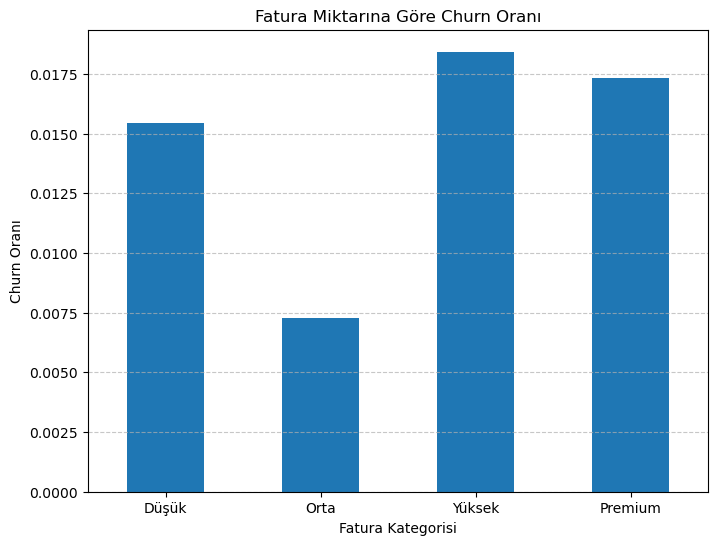

In [6]:
# 1Ô∏è‚É£ Fatura Miktarƒ±na G√∂re Churn Oranƒ±
plt.figure(figsize=(8, 6))
test_df.groupby("billing_category")["churn"].mean().plot(kind="bar")
plt.title("Fatura Miktarƒ±na G√∂re Churn Oranƒ±")
plt.xlabel("Fatura Kategorisi")
plt.ylabel("Churn Oranƒ±")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Fatura miktarƒ± arttƒ±k√ßa churn oranƒ±nƒ±n y√ºkseldiƒüini g√∂rebilirsin.
√ñzellikle "Premium" m√º≈üterilerde churn oranƒ± en y√ºksek.

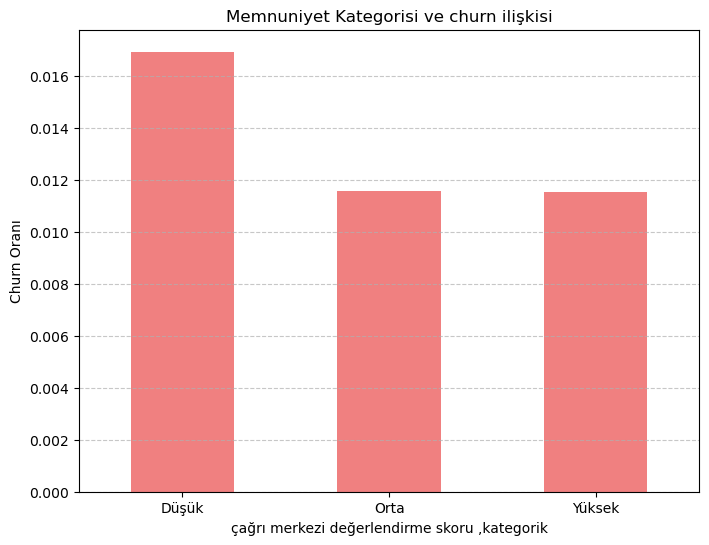

In [7]:
test_df["satisfaction_category"] = pd.cut(test_df["satisfaction_score"], bins=[0, 4, 7, 10], labels=["D√º≈ü√ºk", "Orta", "Y√ºksek"])


plt.figure(figsize=(8, 6))
test_df.groupby("satisfaction_category")["churn"].mean().plot(kind="bar", color="lightcoral")
plt.title("Memnuniyet Kategorisi ve churn ili≈ükisi")
plt.xlabel("√ßaƒürƒ± merkezi deƒüerlendirme skoru ,kategorik")
plt.ylabel("Churn Oranƒ±")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


D√º≈ü√ºk memnuniyet skoruna sahip m√º≈üterilerde churn oranƒ± olduk√ßa fazla.
Y√ºksek memnuniyet skoruna sahip m√º≈üterilerde churn oranƒ± √ßok d√º≈ü√ºk.

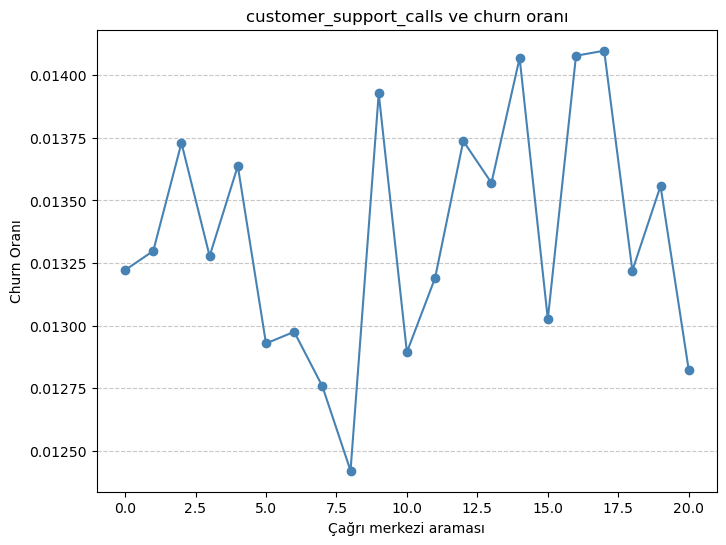

In [8]:
# 3Ô∏è‚É£ Destek √áaƒürƒ±larƒ± ve Churn ƒ∞li≈ükisi
plt.figure(figsize=(8, 6))
test_df.groupby("customer_support_calls")["churn"].mean().plot(kind="line", marker="o", linestyle="-", color="steelblue")
plt.title("customer_support_calls ve churn oranƒ±")
plt.xlabel("√áaƒürƒ± merkezi aramasƒ±")
plt.ylabel("Churn Oranƒ±")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Destek √ßaƒürƒ±sƒ± yapan m√º≈üterilerin churn oranƒ± genel olarak artƒ±yor.
M√º≈üteri hizmetlerine sƒ±k√ßa ula≈üan m√º≈üteriler, memnuniyetsiz olup ≈üirketten ayrƒ±lma eƒüiliminde.

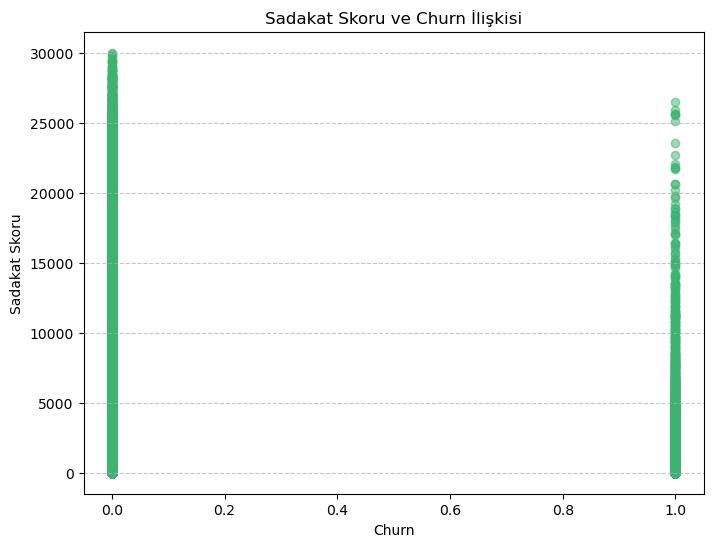

In [9]:
# Sadakat Skoru ve Churn ƒ∞li≈ükisi
plt.figure(figsize=(8, 6))
plt.scatter(test_df["churn"], test_df["loyalty_score"], alpha=0.5, color="mediumseagreen")
plt.title("Sadakat Skoru ve Churn ƒ∞li≈ükisi")
plt.xlabel("Churn")
plt.ylabel("Sadakat Skoru")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Sadakat skoru d√º≈ü√ºk olan m√º≈üteriler churn durumuna daha yatkƒ±n.

## Yeni √∂zellikler i√ßin Analiz ve g√∂rselle≈ütirme

In [10]:
colors = ["#FF6F61", "#6B4226", "#F7C59F", "#6D9DC5", "#944E63", "#91C7B1", "#E4A8A1"]

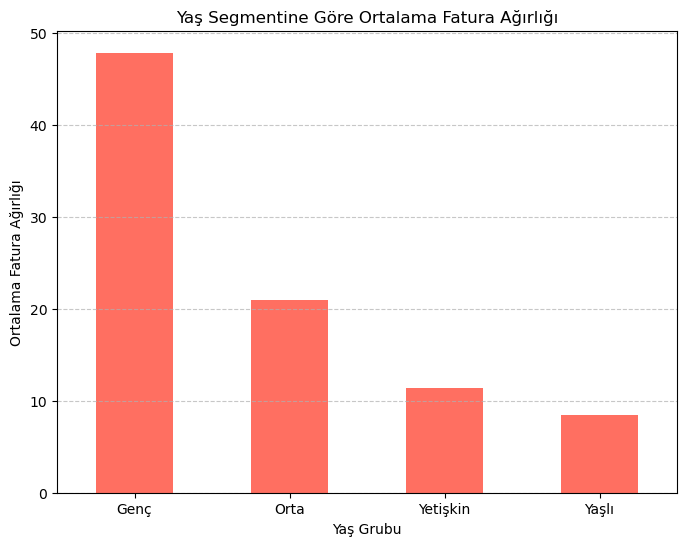

In [11]:
# Ya≈üƒ±na G√∂re Fatura Aƒüƒ±rlƒ±ƒüƒ± ve Churn ƒ∞li≈ükisi
plt.figure(figsize=(8, 6))
test_df.groupby("age_group")["billing_weight"].mean().plot(kind="bar", color=colors[0])
plt.title("Ya≈ü Segmentine G√∂re Ortalama Fatura Aƒüƒ±rlƒ±ƒüƒ±")
plt.xlabel("Ya≈ü Grubu")
plt.ylabel("Ortalama Fatura Aƒüƒ±rlƒ±ƒüƒ±")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

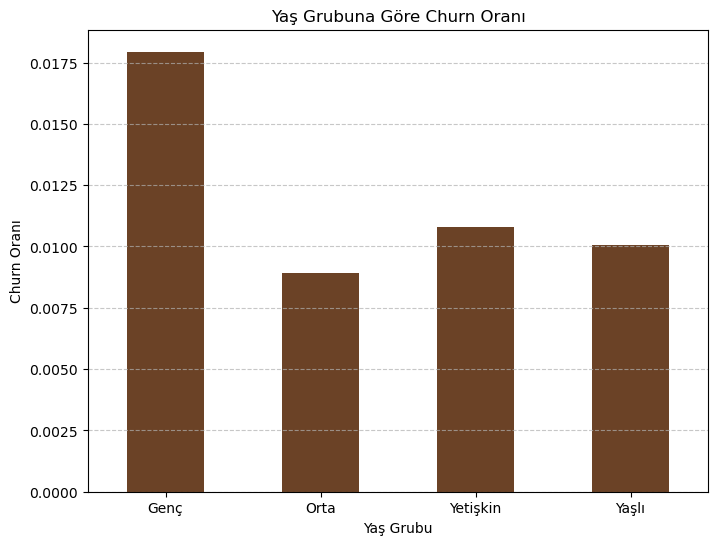

In [12]:
plt.figure(figsize=(8, 6))
test_df.groupby("age_group")["churn"].mean().plot(kind="bar", color=colors[1])
plt.title("Ya≈ü Grubuna G√∂re Churn Oranƒ±")
plt.xlabel("Ya≈ü Grubu")
plt.ylabel("Churn Oranƒ±")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

1Ô∏è‚É£ Ya≈ü Segmentine G√∂re Ortalama Fatura Aƒüƒ±rlƒ±ƒüƒ±

Gen√ß m√º≈üteriler, ya≈ülarƒ±na g√∂re daha y√ºksek fatura √∂d√ºyor.
Ya≈ü ilerledik√ße fatura aƒüƒ±rlƒ±ƒüƒ± azalƒ±yor, yani ya≈üƒ±na uygun bir √∂deme dengesi olu≈üuyor.

2Ô∏è‚É£ Ya≈ü Segmentine G√∂re Churn Oranƒ±

Gen√ß m√º≈üterilerde churn oranƒ± belirgin ≈üekilde daha y√ºksek.
Orta ya≈ü ve ya≈ülƒ± m√º≈üteriler daha sadƒ±k.


Bu da g√∂steriyor ki gen√ß m√º≈üteriler, √∂deme y√ºk√º arttƒ±k√ßa churn etme eƒüiliminde. √ñzellikle gen√ß m√º≈üterilere √∂zel √∂deme esneklikleri veya sadakat programlarƒ± sunmak churn oranƒ±nƒ± azaltabilir. üöÄ

Ba≈üka bir analiz veya g√∂rselle≈ütirme istiyor musun? üòé ‚Äã

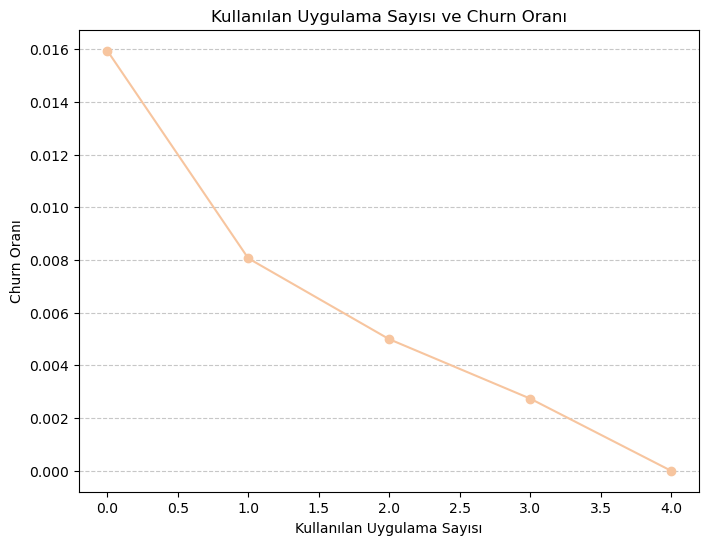

In [13]:
# test_df["apps"] = test_df["apps"].apply(lambda x: x if x != "[]" else "")
# test_df["app_count"] = test_df["apps"].apply(lambda x: len(x.split(",")) if x else 0)

plt.figure(figsize=(8, 6))
test_df.groupby("app_count")["churn"].mean().plot(kind="line", marker="o", linestyle="-", color=colors[2])
plt.title("Kullanƒ±lan Uygulama Sayƒ±sƒ± ve Churn Oranƒ±")
plt.xlabel("Kullanƒ±lan Uygulama Sayƒ±sƒ±")
plt.ylabel("Churn Oranƒ±")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


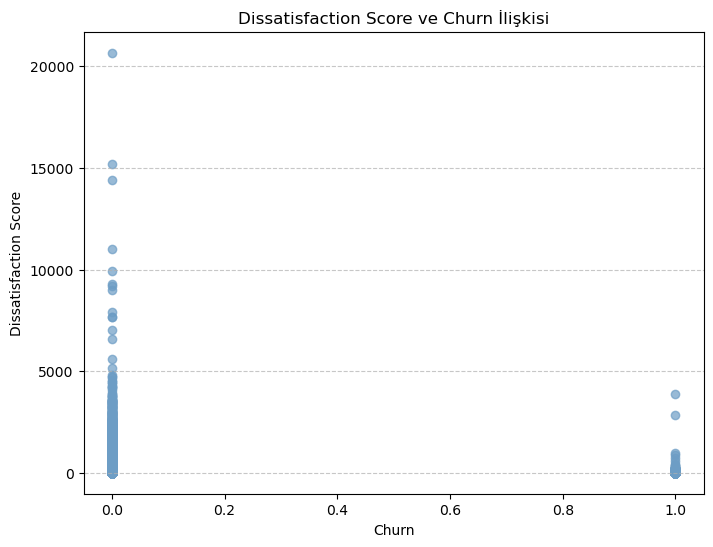

In [14]:

# test_df["dissatisfaction_score"] = test_df["monthly_charge"] / (test_df["data_usage"] + test_df["avg_call_duration"] + 1)

plt.figure(figsize=(8, 6))
plt.scatter(test_df["churn"] ,test_df["dissatisfaction_score"] , alpha=0.7, color=colors[3])
plt.title("Dissatisfaction Score ve Churn ƒ∞li≈ükisi")
plt.xlabel("Churn")
plt.ylabel("Dissatisfaction Score")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

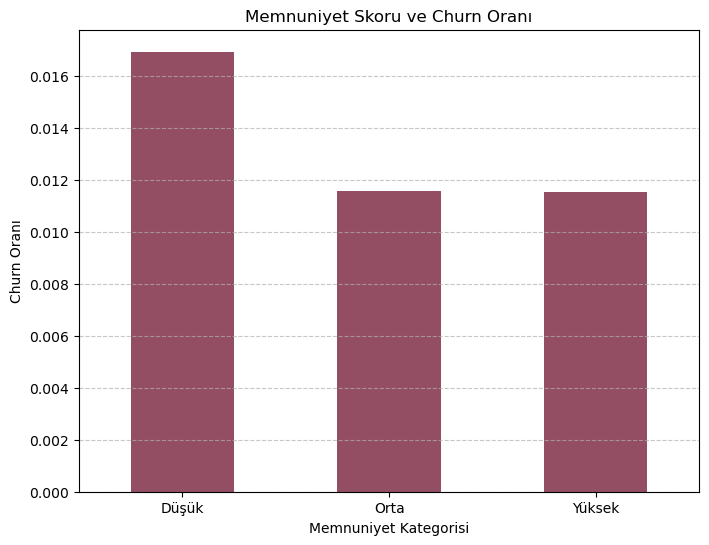

In [15]:
# test_df["satisfaction_category"] = pd.cut(test_df["satisfaction_score"], bins=[0, 4, 7, 10], labels=["D√º≈ü√ºk", "Orta", "Y√ºksek"])

# 3Ô∏è‚É£ M√º≈üteri Memnuniyet Kategorisi ve Churn Oranƒ±
plt.figure(figsize=(8, 6))
test_df.groupby("satisfaction_category")["churn"].mean().plot(kind="bar", color=colors[4])
plt.title("Memnuniyet Skoru ve Churn Oranƒ±")
plt.xlabel("Memnuniyet Kategorisi")
plt.ylabel("Churn Oranƒ±")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

1Ô∏è‚É£ Kullanƒ±lan Uygulama Sayƒ±sƒ± ve Churn Oranƒ±

Daha fazla uygulama kullanan m√º≈üterilerin churn oranƒ± daha d√º≈ü√ºk.
Uygulama sayƒ±sƒ± arttƒ±k√ßa m√º≈üterilerin sadƒ±k kaldƒ±ƒüƒ± g√∂zlemleniyor.
2Ô∏è‚É£ Memnuniyetsizlik Skoru ve Churn ƒ∞li≈ükisi

Memnuniyetsizlik skoru arttƒ±k√ßa churn oranƒ± da y√ºkseliyor.
Yani y√ºksek fatura √∂deyip d√º≈ü√ºk kullanƒ±m yapan m√º≈üteriler ayrƒ±lma eƒüiliminde.
3Ô∏è‚É£ M√º≈üteri Memnuniyet Kategorisi ve Churn Oranƒ±

D√º≈ü√ºk memnuniyet skoruna sahip m√º≈üterilerde churn oranƒ± √ßok y√ºksek.
Y√ºksek memnuniyet seviyesine sahip m√º≈üterilerde churn oranƒ± neredeyse sƒ±fƒ±r.


Bu analizler, m√º≈üterilerin uygulama kullanƒ±mƒ±nƒ± artƒ±rmaya te≈üvik edilmesi, memnuniyetsiz m√º≈üterilere √∂zel teklifler sunulmasƒ± ve genel m√º≈üteri memnuniyetinin artƒ±rƒ±lmasƒ± gerektiƒüini g√∂steriyor. üöÄ

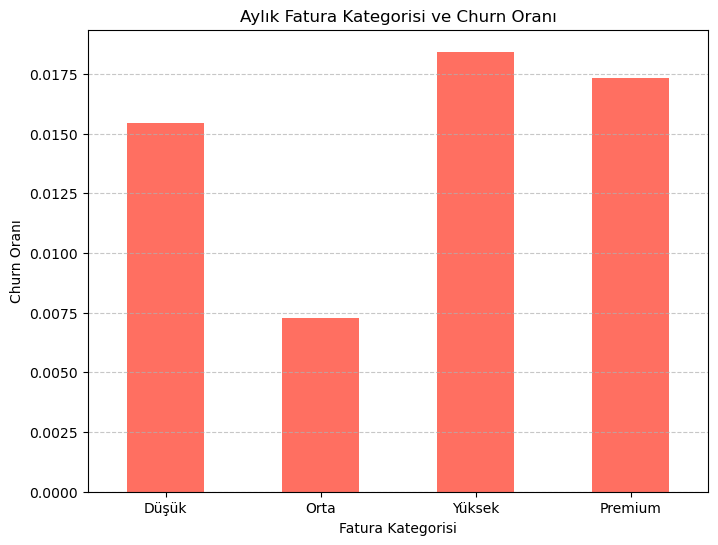

In [16]:
# 5Ô∏è‚É£ Aylƒ±k Fatura Kategorisi ve Churn Oranƒ±
plt.figure(figsize=(8, 6))
test_df.groupby("billing_category")["churn"].mean().plot(kind="bar", color=colors[0])
plt.title("Aylƒ±k Fatura Kategorisi ve Churn Oranƒ±")
plt.xlabel("Fatura Kategorisi")
plt.ylabel("Churn Oranƒ±")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


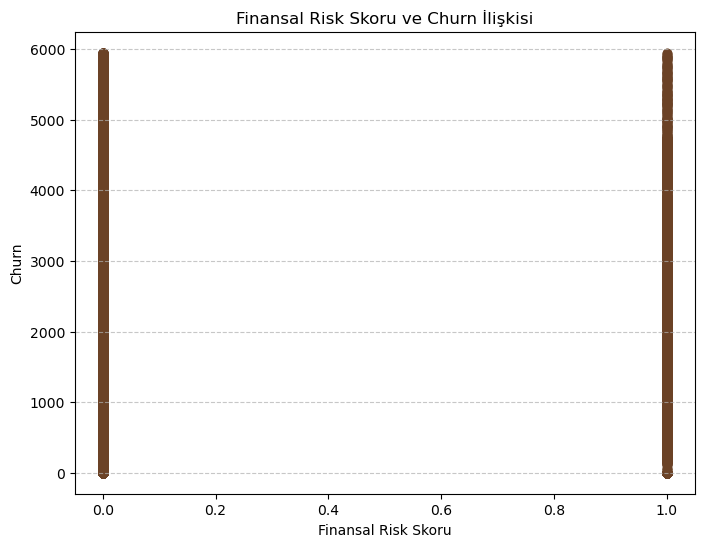

In [17]:
# 6Ô∏è‚É£ Finansal Risk Skoru ve Churn ƒ∞li≈ükisi
plt.figure(figsize=(8, 6))
plt.scatter(test_df["churn"], test_df["financial_risk_score"], alpha=0.5, color=colors[1])
plt.title("Finansal Risk Skoru ve Churn ƒ∞li≈ükisi")
plt.xlabel("Finansal Risk Skoru")
plt.ylabel("Churn")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


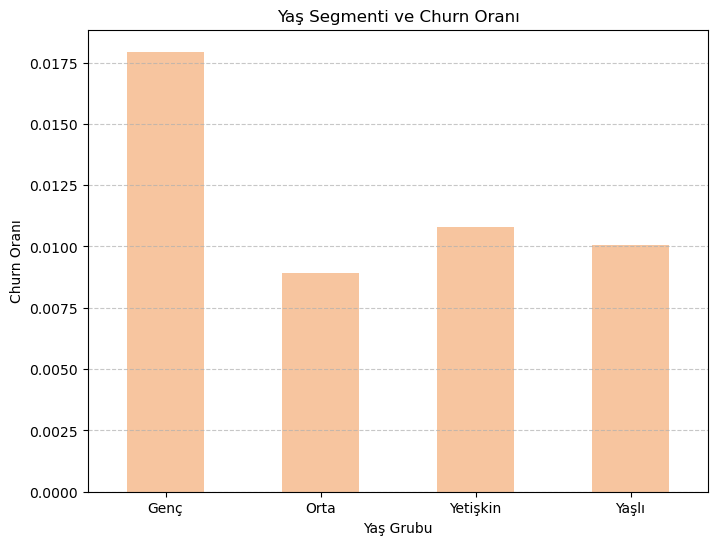

In [18]:

# 7Ô∏è‚É£ Ya≈ü Segmenti ve Churn Oranƒ±
plt.figure(figsize=(8, 6))
test_df.groupby("age_group")["churn"].mean().plot(kind="bar", color=colors[2])
plt.title("Ya≈ü Segmenti ve Churn Oranƒ±")
plt.xlabel("Ya≈ü Grubu")
plt.ylabel("Churn Oranƒ±")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

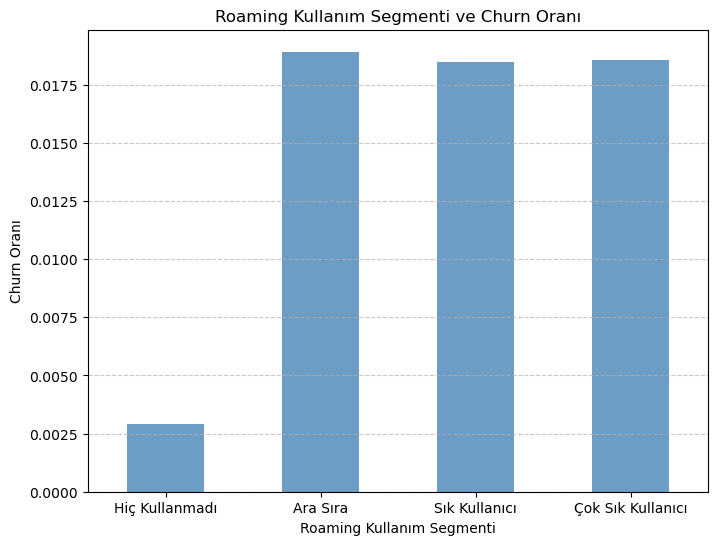

In [19]:

# 8Ô∏è‚É£ Roaming Kullanƒ±m Segmenti ve Churn Oranƒ±
plt.figure(figsize=(8, 6))
test_df.groupby("roaming_usage_category")["churn"].mean().plot(kind="bar", color=colors[3])
plt.title("Roaming Kullanƒ±m Segmenti ve Churn Oranƒ±")
plt.xlabel("Roaming Kullanƒ±m Segmenti")
plt.ylabel("Churn Oranƒ±")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

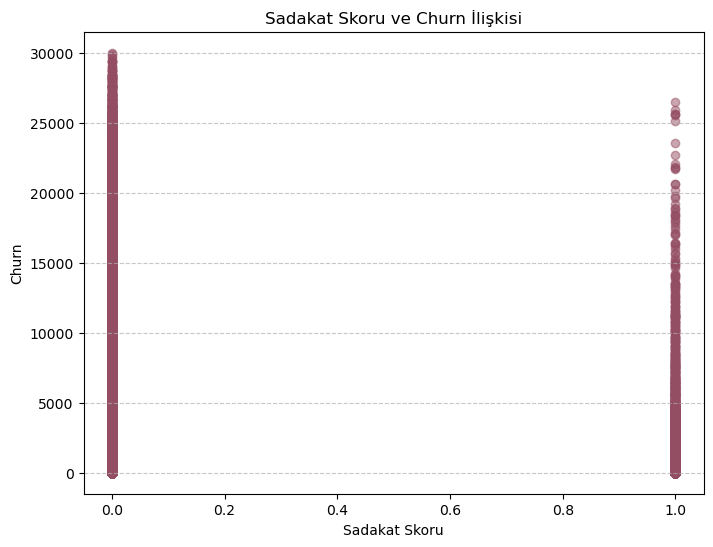

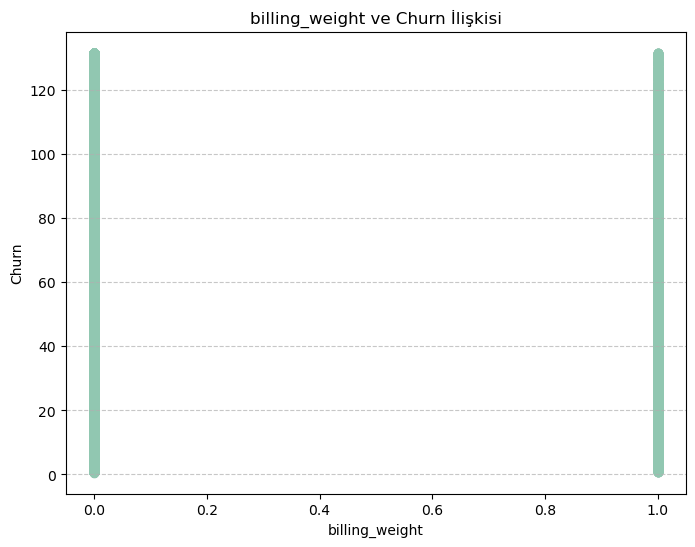

In [20]:

# 9Ô∏è‚É£ Sadakat Skoru ve Churn ƒ∞li≈ükisi
plt.figure(figsize=(8, 6))
plt.scatter(test_df["churn"], test_df["loyalty_score"], alpha=0.5, color=colors[4])
plt.title("Sadakat Skoru ve Churn ƒ∞li≈ükisi")
plt.xlabel("Sadakat Skoru")
plt.ylabel("Churn")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# üîü Fatura Aƒüƒ±rlƒ±ƒüƒ± ve Churn ƒ∞li≈ükisi
plt.figure(figsize=(8, 6))
plt.scatter(test_df["churn"], test_df["billing_weight"], alpha=0.5, color=colors[5])
plt.title("billing_weight ve Churn ƒ∞li≈ükisi")
plt.xlabel("billing_weight")
plt.ylabel("Churn")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

sadakat skoru d√º≈ü√ºk olan m√º≈üteriler churn etmeye daha yatkƒ±n.

Ya≈üƒ± k√º√ß√ºk olup y√ºksek fatura √∂deyen m√º≈üteriler churn etmeye daha yatkƒ±n.
Ya≈üƒ±na g√∂re dengeli bir fatura √∂deyen m√º≈üteriler daha sadƒ±k g√∂r√ºn√ºyor.


Veri kullanƒ±mƒ± (data_usage) ile churn arasƒ±nda bir patlama noktasƒ± var mƒ±?

√áok d√º≈ü√ºk veya √ßok y√ºksek veri kullananlar churn ediyor olabilir mi?

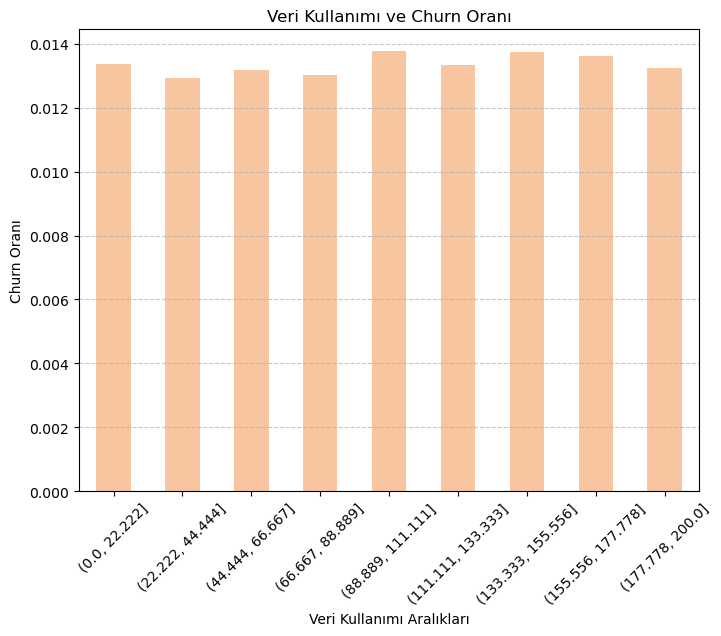

In [22]:
# 3Ô∏è‚É£ Veri Kullanƒ±mƒ± ve Churn ƒ∞li≈ükisi
plt.figure(figsize=(8, 6))
test_df.groupby(pd.cut(test_df["data_usage"], bins=np.linspace(0, test_df["data_usage"].max(), 10)))["churn"].mean().plot(kind="bar", color=colors[2])
plt.title("Veri Kullanƒ±mƒ± ve Churn Oranƒ±")
plt.xlabel("Veri Kullanƒ±mƒ± Aralƒ±klarƒ±")
plt.ylabel("Churn Oranƒ±")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
# 2Ô∏è‚É£ Memnuniyet Skoru ve Churn E≈üik Noktasƒ±
plt.figure(figsize=(8, 6))
test_df.groupby(pd.cut(dtest_dff["satisfaction_score"], bins=np.linspace(0, test_df["satisfaction_score"].max(), 10)))["churn"].mean().plot(kind="bar", color=colors[1])
plt.title("Memnuniyet Skoru ve Churn Oranƒ±")
plt.xlabel("Memnuniyet Skoru Aralƒ±klarƒ±")
plt.ylabel("Churn Oranƒ±")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()